In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

In [4]:
data = pd.read_csv("../data/final_merged_data.csv")
data = data.iloc[:, 1:] # drop first index column
data

,Date,Ticker,Risk_Premium,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Dividends_lag_1,Stock Splits_lag_1,...,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,1999-05-01,AAPL,-0.087120,0.271611,0.354930,0.252311,0.346457,1.588897e+10,0.0,0.0,...,0.122936,4.0,0.049323,1.207631e-10,0.117557,0.042242,0.657432,32.287511,1.986735e-09,36.0
1,1999-06-01,AAPL,0.005363,0.346927,0.376584,0.308327,0.331864,8.908906e+09,0.0,0.0,...,0.122936,4.0,0.051719,1.757727e-10,0.077446,0.038724,0.484583,18.364520,3.712020e-09,36.0
2,1999-07-01,AAPL,0.156931,0.338925,0.369052,0.316801,0.348810,6.918621e+09,0.0,0.0,...,0.123397,4.0,0.034514,2.044230e-10,0.066079,0.027887,0.445337,8.414747,4.302510e-09,36.0
3,1999-08-01,AAPL,0.124516,0.348810,0.426481,0.340338,0.419420,1.146658e+10,0.0,0.0,...,0.123397,4.0,0.044134,1.495828e-10,0.092732,0.035853,0.688701,28.090011,2.755259e-09,36.0
4,1999-09-01,AAPL,-0.076493,0.418949,0.496149,0.392589,0.491441,9.244603e+09,0.0,0.0,...,0.123397,4.0,0.037899,7.821210e-11,0.077878,0.026111,0.330843,9.621266,3.255809e-09,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52491,2021-08-01,ZBRA,0.062290,530.000000,554.219971,502.630005,552.479980,4.412900e+06,0.0,0.0,...,0.117282,7.0,0.021645,1.105170e-10,0.027133,0.014723,0.215228,0.855580,2.539391e-08,35.0
52492,2021-09-01,ZBRA,-0.122596,555.000000,594.140015,527.539978,587.169983,4.195600e+06,0.0,0.0,...,0.117282,7.0,0.019300,8.389667e-11,0.024253,0.010630,0.365352,1.552494,2.545416e-08,35.0
52493,2021-10-01,ZBRA,0.035451,592.479980,594.770020,514.989990,515.419983,5.111900e+06,0.0,0.0,...,0.117282,7.0,0.021224,8.733136e-11,0.010877,0.013933,0.351185,1.773701,2.191674e-08,35.0
52494,2021-11-01,ZBRA,0.102188,517.619995,543.489990,491.989990,533.950012,4.694900e+06,0.0,0.0,...,0.116757,7.0,0.020637,1.027103e-10,0.029163,0.013376,0.292110,1.568994,2.390712e-08,35.0


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Configuration
window_size = 172  # Number of months to use for training
oos_months = 1    # Number of months to predict
total_months = 272  # Total number of months (for example, 2 years of data)
num_stocks = 193   # Total number of stocks

# Load characteristics and returns data
c = data.drop(columns=['Date', "Risk_Premium"])  # Characteristics data (shape: [total_months * num_stocks, num_features]), num_features = 116
r1 = data[['Risk_Premium']]  # Returns data (shape: [total_months * num_stocks])

In [6]:
# one-hot encoding ticker (categoritcal variable to dummy)
c_encoded = pd.get_dummies(c, drop_first=True)  # Drop first to avoid multicollinearity
c_encoded

,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Dividends_lag_1,Stock Splits_lag_1,Monthly_Return_lag_1,3_Month_Treasury_Bill_Yield_lag_1,6_Month_Treasury_Bill_Yield_lag_1,...,Ticker_VOXX,Ticker_VRSN,Ticker_VSAT,Ticker_VSH,Ticker_VYX,Ticker_WDC,Ticker_WOLF,Ticker_WYY,Ticker_XRX,Ticker_ZBRA
0,0.271611,0.354930,0.252311,0.346457,1.588897e+10,0.0,0.0,0.279997,0.0429,0.0437,...,0,0,0,0,0,0,0,0,0,0
1,0.346927,0.376584,0.308327,0.331864,8.908906e+09,0.0,0.0,-0.042120,0.0450,0.0456,...,0,0,0,0,0,0,0,0,0,0
2,0.338925,0.369052,0.316801,0.348810,6.918621e+09,0.0,0.0,0.051063,0.0457,0.0482,...,0,0,0,0,0,0,0,0,0,0
3,0.348810,0.426481,0.340338,0.419420,1.146658e+10,0.0,0.0,0.202431,0.0455,0.0458,...,0,0,0,0,0,0,0,0,0,0
4,0.418949,0.496149,0.392589,0.491441,9.244603e+09,0.0,0.0,0.171716,0.0472,0.0487,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52491,530.000000,554.219971,502.630005,552.479980,4.412900e+06,0.0,0.0,0.043419,0.0005,0.0005,...,0,0,0,0,0,0,0,0,0,1
52492,555.000000,594.140015,527.539978,587.169983,4.195600e+06,0.0,0.0,0.062790,0.0005,0.0006,...,0,0,0,0,0,0,0,0,0,1
52493,592.479980,594.770020,514.989990,515.419983,5.111900e+06,0.0,0.0,-0.122196,0.0004,0.0005,...,0,0,0,0,0,0,0,0,0,1
52494,517.619995,543.489990,491.989990,533.950012,4.694900e+06,0.0,0.0,0.035951,0.0005,0.0006,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# Check for columns with missing values
missing_columns = c_encoded.isna().any()

print("Columns with missing values:")
print(missing_columns[missing_columns]) 

c_encoded[c_encoded['mvel1'].isna()]

Columns with missing values:
mvel1         True
beta          True
betasq        True
chmom         True
dolvol        True
              ... 
retvol        True
std_dolvol    True
std_turn      True
zerotrade     True
sic2          True
Length: 95, dtype: bool


,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Dividends_lag_1,Stock Splits_lag_1,Monthly_Return_lag_1,3_Month_Treasury_Bill_Yield_lag_1,6_Month_Treasury_Bill_Yield_lag_1,...,Ticker_VOXX,Ticker_VRSN,Ticker_VSAT,Ticker_VSH,Ticker_VYX,Ticker_WDC,Ticker_WOLF,Ticker_WYY,Ticker_XRX,Ticker_ZBRA
5984,51.000000,81.000,43.125000,76.500000,3533264.0,0.0,0.0,0.522388,0.0429,0.0437,...,0,0,0,0,0,0,0,0,0,0
5985,76.875000,91.125,67.875000,75.750000,2281500.0,0.0,0.0,-0.009804,0.0450,0.0456,...,0,0,0,0,0,0,0,0,0,0
5986,76.125000,91.500,63.750000,76.500000,3283050.0,0.0,0.0,0.009901,0.0457,0.0482,...,0,0,0,0,0,0,0,0,0,0
5987,76.125000,91.500,68.625000,71.250000,2317032.0,0.0,0.0,-0.068627,0.0455,0.0458,...,0,0,0,0,0,0,0,0,0,0
5988,70.875000,90.000,63.000000,82.125000,2424733.0,0.0,0.0,0.152632,0.0472,0.0487,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51764,25.500000,31.500,25.200001,29.500000,699360.0,0.0,0.0,0.130268,0.0460,0.0472,...,0,0,0,0,0,0,0,1,0,0
51765,29.799999,30.500,26.500000,28.200001,716170.0,0.0,0.0,-0.044068,0.0472,0.0482,...,0,0,0,0,0,0,0,1,0,0
51766,28.000000,30.000,25.000000,28.600000,372500.0,0.0,0.0,0.014184,0.0479,0.0497,...,0,0,0,0,0,0,0,1,0,0
51767,29.700001,30.500,27.299999,28.000000,401900.0,0.0,0.0,-0.020979,0.0495,0.0506,...,0,0,0,0,0,0,0,1,0,0


In [8]:
# Add a column indicating if any row has NA and impute missing values
c_encoded['has_na'] = c_encoded.isna().any(axis=1)

# Impute missing values with the mean for numerical columns
imputer = SimpleImputer(strategy='mean')
c_encoded.iloc[:, :-1] = imputer.fit_transform(c_encoded.iloc[:, :-1])
c_encoded

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_76002/310738126.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  c_encoded.iloc[:, :-1] = imputer.fit_transform(c_encoded.iloc[:, :-1])


,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Dividends_lag_1,Stock Splits_lag_1,Monthly_Return_lag_1,3_Month_Treasury_Bill_Yield_lag_1,6_Month_Treasury_Bill_Yield_lag_1,...,Ticker_VRSN,Ticker_VSAT,Ticker_VSH,Ticker_VYX,Ticker_WDC,Ticker_WOLF,Ticker_WYY,Ticker_XRX,Ticker_ZBRA,has_na
0,0.271611,0.354930,0.252311,0.346457,1.588897e+10,0.0,0.0,0.279997,0.0429,0.0437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,0.346927,0.376584,0.308327,0.331864,8.908906e+09,0.0,0.0,-0.042120,0.0450,0.0456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.338925,0.369052,0.316801,0.348810,6.918621e+09,0.0,0.0,0.051063,0.0457,0.0482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.348810,0.426481,0.340338,0.419420,1.146658e+10,0.0,0.0,0.202431,0.0455,0.0458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,0.418949,0.496149,0.392589,0.491441,9.244603e+09,0.0,0.0,0.171716,0.0472,0.0487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52491,530.000000,554.219971,502.630005,552.479980,4.412900e+06,0.0,0.0,0.043419,0.0005,0.0005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
52492,555.000000,594.140015,527.539978,587.169983,4.195600e+06,0.0,0.0,0.062790,0.0005,0.0006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
52493,592.479980,594.770020,514.989990,515.419983,5.111900e+06,0.0,0.0,-0.122196,0.0004,0.0005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
52494,517.619995,543.489990,491.989990,533.950012,4.694900e+06,0.0,0.0,0.035951,0.0005,0.0006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [ ]:
# Store results
results = []
feature_importance_list = []  # Store feature importance for each iteration

# Rolling window approach
for start in range(total_months - window_size):
    # Define training and OOS sets
    xtrain = c_encoded[start * num_stocks:(start + window_size) * num_stocks]
    ytrain = r1[start * num_stocks:(start + window_size) * num_stocks]
    xoos = c_encoded[(start + window_size) * num_stocks:(start + window_size + oos_months) * num_stocks]
    yoos = r1[(start + window_size) * num_stocks:(start + window_size + oos_months) * num_stocks]

    # Create and train the Random Forest model
    model = RandomForestRegressor(n_estimators=39, random_state=42) # 117/3 = 39
    model.fit(xtrain, ytrain.values.ravel())

    # Predictions for out-of-sample data
    yhat_oos = model.predict(xoos)

    # Ensure yhat_oos is a 1D array
    yhat_oos = np.array(yhat_oos).flatten()  # This ensures it is 1D

    # Ensure yoos is a 1D array
    yoos = np.array(yoos).flatten()  # Flattening to convert to 1D

    # Ensure ytrain is a 1D array
    ytrain_flat = np.array(ytrain).flatten()  # Flattening ytrain

    # Calculate R-squared for out-of-sample dataset
    r_squared_oos = 1 - np.sum(np.power(yhat_oos - yoos, 2)) / np.sum(np.power(yoos - np.mean(ytrain_flat), 2))

    # Store feature importance
    feature_importance_list.append(model.feature_importances_)

    # Store results, including predicted returns
    for i in range(len(yhat_oos)):
        results.append({
            'start_month': start,
            'R_squared_oos': r_squared_oos,
            'predicted_return': yhat_oos[i],
            'actual_return': yoos[i]
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print(results_df)

# Convert feature importance to DataFrame
feature_importance_df = pd.DataFrame(feature_importance_list, columns=[f'Feature_{i}' for i in range(c_encoded.shape[1])])

       start_month  R_squared_oos  predicted_return  actual_return
0                0       0.320882         -0.129660      -0.053862
1                0       0.320882          0.166256       0.202260
2                0       0.320882         -0.064203      -0.134121
3                0       0.320882          0.179861      -0.060900
4                0       0.320882         -0.170855      -0.495583
...            ...            ...               ...            ...
19295           99       0.419870          0.017562       0.062290
19296           99       0.419870         -0.001495      -0.122596
19297           99       0.419870          0.042612       0.035451
19298           99       0.419870          0.010324       0.102188
19299           99       0.419870          0.049783       0.010304

[19300 rows x 4 columns]


In [13]:
results_df

,start_month,R_squared_oos,predicted_return,actual_return
0,0,0.320882,-0.129660,-0.053862
1,0,0.320882,0.166256,0.202260
2,0,0.320882,-0.064203,-0.134121
3,0,0.320882,0.179861,-0.060900
4,0,0.320882,-0.170855,-0.495583
...,...,...,...,...
19295,99,0.419870,0.017562,0.062290
19296,99,0.419870,-0.001495,-0.122596
19297,99,0.419870,0.042612,0.035451
19298,99,0.419870,0.010324,0.102188


In [18]:
# Rename columns of feature importance DataFrame to match original dataset
feature_importance_df.columns = c_encoded.columns
feature_importance_df

,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Dividends_lag_1,Stock Splits_lag_1,Monthly_Return_lag_1,3_Month_Treasury_Bill_Yield_lag_1,6_Month_Treasury_Bill_Yield_lag_1,...,Ticker_VRSN,Ticker_VSAT,Ticker_VSH,Ticker_VYX,Ticker_WDC,Ticker_WOLF,Ticker_WYY,Ticker_XRX,Ticker_ZBRA,has_na
0,0.013160,0.011691,0.008325,0.010902,0.014823,0.001307,0.000076,0.011903,0.019662,0.020234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000306
1,0.008573,0.010210,0.010098,0.011693,0.017904,0.001113,0.000101,0.011287,0.018032,0.019127,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298
2,0.008536,0.009131,0.016317,0.010286,0.012597,0.001138,0.000077,0.013753,0.019418,0.019965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000342
3,0.009443,0.007224,0.023222,0.017722,0.020788,0.001067,0.000094,0.013027,0.032838,0.021842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336
4,0.013759,0.016145,0.019500,0.011525,0.012571,0.001239,0.000097,0.012089,0.027364,0.020809,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.007616,0.007362,0.012402,0.009610,0.011388,0.001060,0.000174,0.009666,0.016100,0.014698,...,0.000049,0.000116,0.000053,0.000077,0.000051,0.000109,0.000000,0.000000,0.000000,0.000220
96,0.007767,0.006506,0.013051,0.009989,0.018677,0.001245,0.000245,0.010072,0.026363,0.016947,...,0.000025,0.000110,0.000042,0.000051,0.000040,0.000173,0.000746,0.000000,0.000000,0.000302
97,0.007348,0.014951,0.011660,0.009685,0.012084,0.001183,0.000178,0.009710,0.014718,0.018585,...,0.000005,0.000080,0.000025,0.000077,0.000059,0.000171,0.001279,0.000000,0.000000,0.000206
98,0.014124,0.006784,0.014789,0.009887,0.011939,0.001390,0.000136,0.010052,0.019301,0.018306,...,0.000030,0.000099,0.000038,0.000072,0.000061,0.000120,0.001561,0.000007,0.000000,0.000219


In [ ]:
mean_importance = feature_importance_df.mean().sort_values(ascending=False)
mean_importance

std_turn                            4.919011e-02
Oil_Price_WTI_change_lag_1          3.897229e-02
Rolling_Return_3M_lag_1             2.934082e-02
AAA_Bond_Yield_lag_1                2.924873e-02
1_Year_Treasury_Bill_Yield_lag_1    2.681308e-02
                                        ...     
Ticker_APH                          8.274603e-07
Ticker_XRX                          2.454730e-07
Ticker_ADP                          2.128668e-07
Ticker_ZBRA                         2.752887e-08
sin                                 0.000000e+00
Length: 308, dtype: float64

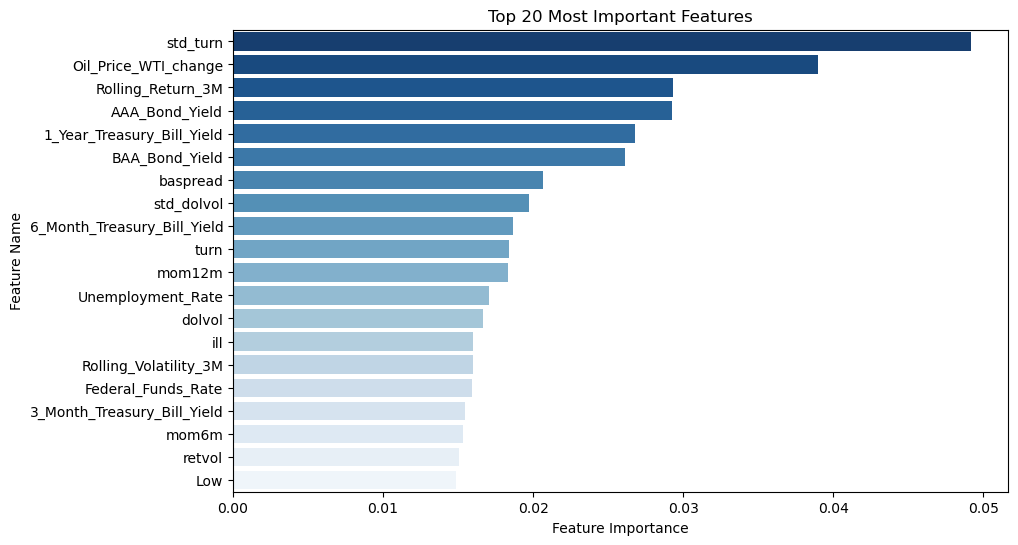

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Series to DataFrame
mean_importance_df = mean_importance.reset_index()
mean_importance_df.columns = ["Feature", "Importance"]  # Rename columns
mean_importance_df["Feature"] = mean_importance_df["Feature"].str.replace("_lag_1$", "", regex=True)

# Select top 20 most important features
top_features = mean_importance_df.head(20)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="Blues_r")

# Labels and title
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features")
plt.show()

In [30]:
results_df.to_csv('../data/model_results/random_forest_results.csv', index=True)

In [31]:
feature_importance_df.to_csv('../data/model_results/random_forest_features.csv', index=True)

In [14]:
# get overall OOS R-squared
results_df = pd.read_csv("../data/model_results/random_forest_results.csv")
results_df["R_squared_oos"].mean()

0.18700808554589887

In [15]:
# Define the fixed investment amount
fixed_investment = 1000  # Amount to invest each month

# Create a DataFrame for cumulative returns
investment_results = []  # To store cumulative returns
cumulative_return = 0.0  # Start with zero cumulative return

# Loop through each unique month in the results
for month in sorted(results_df['start_month'].unique()):
    # Select the stocks for the current month
    current_month_stocks = results_df[results_df['start_month'] == month]

    if not current_month_stocks.empty:
        # Select the top 10% stocks based on predicted returns
        top_10_percent_threshold = current_month_stocks['predicted_return'].quantile(0.90)
        current_top_stocks = current_month_stocks[current_month_stocks['predicted_return'] >= top_10_percent_threshold]

        # Use the risk premium as the monthly return
        monthly_returns = current_top_stocks['actual_return'].values
        
        # Calculate the average risk premium of the selected top stocks
        if len(monthly_returns) > 0:
            average_monthly_return = monthly_returns.mean()  # Average risk premium
            
            # Calculate total return from the fixed investment
            cumulative_return += average_monthly_return * fixed_investment

            # Store the result for this month
            investment_results.append({
                'month': month,
                'cumulative_return': cumulative_return
            })

# Convert results to DataFrame
investment_df = pd.DataFrame(investment_results)

# Display cumulative returns
print(investment_df)

    month  cumulative_return
0       0         140.174719
1       1         375.785292
2       2         804.328881
3       3         935.074272
4       4        1090.592786
..    ...                ...
95     95       14192.881038
96     96       14343.290595
97     97       14457.365744
98     98       14564.331133
99     99       14682.668788

[100 rows x 2 columns]
